установим библиотеки, если они не установлены

In [ ]:
%%capture

# Comment this out if you don't want to install pennylane from this notebook
!pip install pennylane

# Comment this out if you don't want to install matplotlib from this notebook
!pip install matplotlib

# Тестовое задание для Quantum-NN-Hack
### MaxCut:
Нужно разделить вершины неориентированного графа с пятью вершинами и шестью ребрами так, чтобы количество ребер между двумя множествами вершин было наибольшим.
Определим функцию стоимости для данной задачи:
$$Cost = \left( \sum_{i,j=1}^n A_{ij} x_i (1 - x_j) \right),$$
где $A_ij$ - элемент матрицы смежности, $x_i, x_j$ - элемент результирующего вектора вершин 
### QUBO
QUBO матрица и вектор:
$$c_i = \sum_{j=1}^n A_{ij}$$
$$Q_{ij} = -A_{ij}$$
Определим новую функцию стоимости:
$$C(x) = \sum_{j,i=1}^n x_i Q_{ij} x_j + \sum_{i=1}^n c_i x_i = x^T Q x + c^T x$$

Для выполнения квантовых вычислений заменим вектор $x \in \{0, 1\}^n$ на $Z \in \{-1, 1\}^n$:
$$x_i  = \frac{1}{2}(1 - Z_i)$$
Замена:
$$C(Z) = -\sum_{j,i=1}^n \frac{1}{4} Q_{ij} Z_i Z_j + \sum_{i=1}^n \frac{1}{2}\left( c_i + \sum_{j=1}^n Q_{ij} \right) Z_i - \left( \sum_{j,i=1}^n \frac{Q_{ij}}{4} - \sum_{i=1} \frac{c_i}{2} \right)$$

In [4]:
import pennylane as qml
from pennylane import numpy as np

Рассмотрим представленный граф

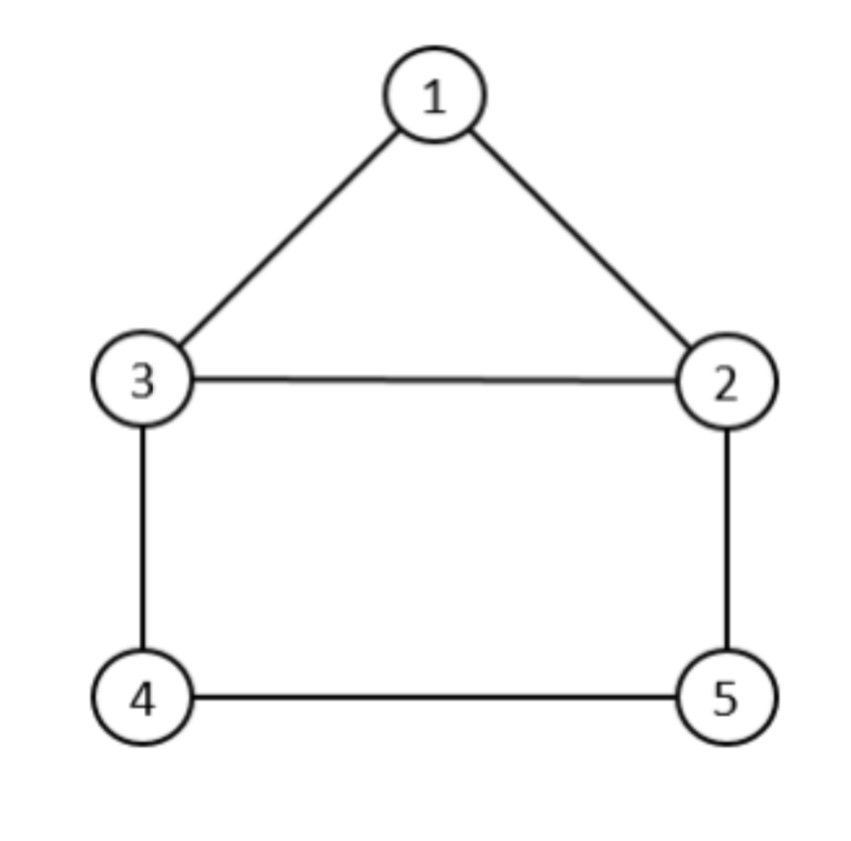

Для данного графа получим следующую формулу:

In [106]:
H = -9 * qml.Identity(1) + \
    0.5 * qml.PauliZ(1) @ qml.PauliZ(3) + \
    0.5 * qml.PauliZ(1) @ qml.PauliZ(2) + \
    0.5 * qml.PauliZ(2) @ qml.PauliZ(3) + \
    0.5 * qml.PauliZ(3) @ qml.PauliZ(4) + \
    0.5 * qml.PauliZ(2) @ qml.PauliZ(5) + \
    0.5 * qml.PauliZ(4) @ qml.PauliZ(5)

Данная Квантовая функция принимает входные параметры `params` и использует их для применения однородных вращений на заданных `H.wires`. Затем код возвращает ожидаемое значение оператора `H`(тензор) для данной квантовой функции.

In [107]:
dev = qml.device("default.qubit", wires = H.wires)

@qml.qnode(dev)
def curcuit(params):

  for param, wire in zip(params, H.wires):
    qml.RY(param, wires=wire)

  return qml.expval(H)

curcuit([0, 0, 0, 0, 0])

tensor(-6., requires_grad=True)

Для решения поставленной задачи нам необходимо использовать оптимизацию градиентного спуска для обучения квантовой функции `circuit` с использованием алгоритма Adagrad.
Создадим массив `params` и запишем в него значения в диапазоне от 0 до 1 для каждого параметра входной функции `H.wires`.
Затем создадим объект оптимизатор `opt` с заданным шагом `stepsize`.
Далее, в цикле с количеством `epochs`, происходит обновление параметров `params` с использованием метода `opt.step` оптимизатора. Для этого вызывается квантовая функция с текущими значениями параметров `params`.
На каждой эпохе параметры обновляются с использованием градиента функции потерь, и цикл повторяется до достижения заданного числа эпох.

In [109]:
params = np.random.rand(len(H.wires))
opt = qml.AdagradOptimizer(stepsize=0.5)
epochs = 200

for epoch in range(epochs):
  params = opt.step(curcuit, params)

curcuit(params)

tensor(-11., requires_grad=True)

Ещё раз запустим квантовый градиентный спуск на разделение графа на подграфы

In [110]:
dev = qml.device("default.qubit", wires = H.wires, shots = 1)

@qml.qnode(dev)
def curcuit(params):

  for param, wire in zip(params, H.wires):
    qml.RY(param, wires=wire)

  return qml.sample()

curcuit(params)

array([0, 0, 1, 0, 1], dtype=int64)

В результате получили следующее разбиение на графы: {1,2,4} и {3,5}. На представленном ниже рисунке наглядно видно, что число связей между этими графами равно 5.

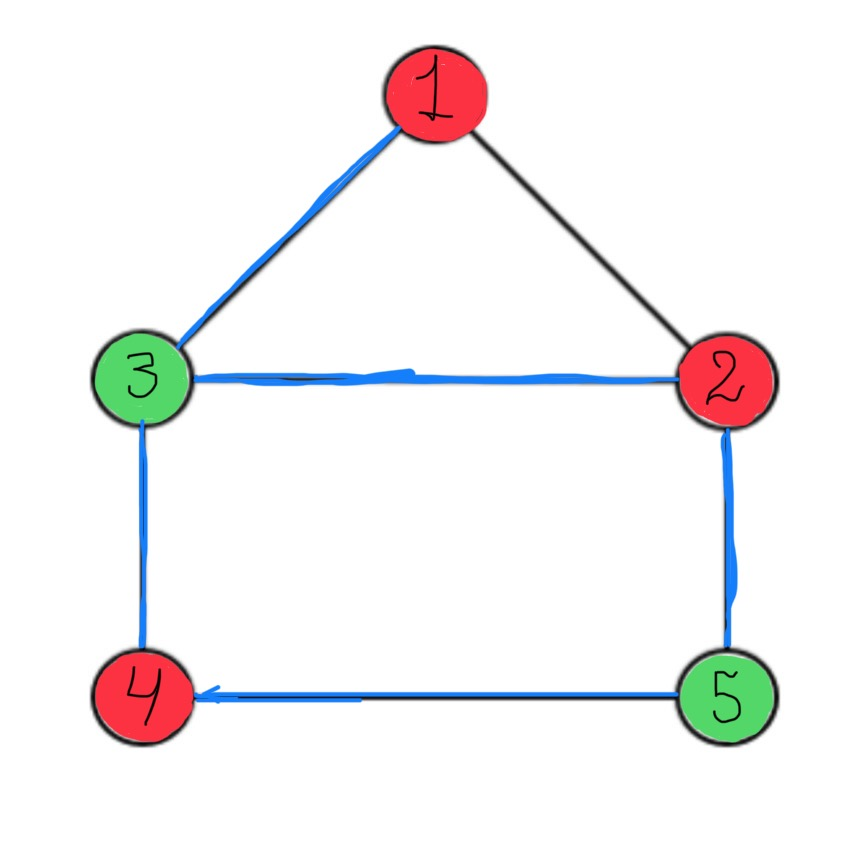

Итог: x = (0, 0, 1, 0, 1); максимальное число ребер - 5